- This notebook is a modification of the original written in this [article](https://medium.com/analytics-vidhya/arima-model-from-scratch-in-python-489e961603ce).
- To have a better understanding of the ARIMA model, I suggest this [article](https://towardsdatascience.com/understanding-arima-time-series-modeling-d99cd11be3f8) written by Tony Yiu.

In [2]:
DATA_PATH = './time_series_covid_19_deaths_US.csv'

P = 2
Q = 2
TRAIN_SIZE = 0.8

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_csv(DATA_PATH)

In [5]:
df

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,109,109,110,110,110,110,110,110,110,110
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,310,310,310,310,310,310,310,310,311,311
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,58,58,58,58,58,58,58,58,59,59
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,64,64,64,64,64,64,64,64,64,64
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,139,139,139,139,139,139,139,139,139,139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,...,9,9,9,9,9,9,9,9,9,9
3338,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,...,13,13,13,13,13,13,13,13,13,13
3339,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3340,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,...,26,26,26,26,26,26,26,26,26,26


In [6]:
df.columns[112:235].values

array(['5/1/20', '5/2/20', '5/3/20', '5/4/20', '5/5/20', '5/6/20',
       '5/7/20', '5/8/20', '5/9/20', '5/10/20', '5/11/20', '5/12/20',
       '5/13/20', '5/14/20', '5/15/20', '5/16/20', '5/17/20', '5/18/20',
       '5/19/20', '5/20/20', '5/21/20', '5/22/20', '5/23/20', '5/24/20',
       '5/25/20', '5/26/20', '5/27/20', '5/28/20', '5/29/20', '5/30/20',
       '5/31/20', '6/1/20', '6/2/20', '6/3/20', '6/4/20', '6/5/20',
       '6/6/20', '6/7/20', '6/8/20', '6/9/20', '6/10/20', '6/11/20',
       '6/12/20', '6/13/20', '6/14/20', '6/15/20', '6/16/20', '6/17/20',
       '6/18/20', '6/19/20', '6/20/20', '6/21/20', '6/22/20', '6/23/20',
       '6/24/20', '6/25/20', '6/26/20', '6/27/20', '6/28/20', '6/29/20',
       '6/30/20', '7/1/20', '7/2/20', '7/3/20', '7/4/20', '7/5/20',
       '7/6/20', '7/7/20', '7/8/20', '7/9/20', '7/10/20', '7/11/20',
       '7/12/20', '7/13/20', '7/14/20', '7/15/20', '7/16/20', '7/17/20',
       '7/18/20', '7/19/20', '7/20/20', '7/21/20', '7/22/20', '7/23/20',
     

In [7]:
raw_data = df.iloc[:, 112:235].sum().reset_index().rename(columns={'index': 'date', 0: 'value'})
raw_data

,date,value
0,5/1/20,68144
1,5/2/20,69875
2,5/3/20,71065
3,5/4/20,72445
4,5/5/20,74687
...,...,...
118,8/27/20,180943
119,8/28/20,181920
120,8/29/20,182822
121,8/30/20,183276


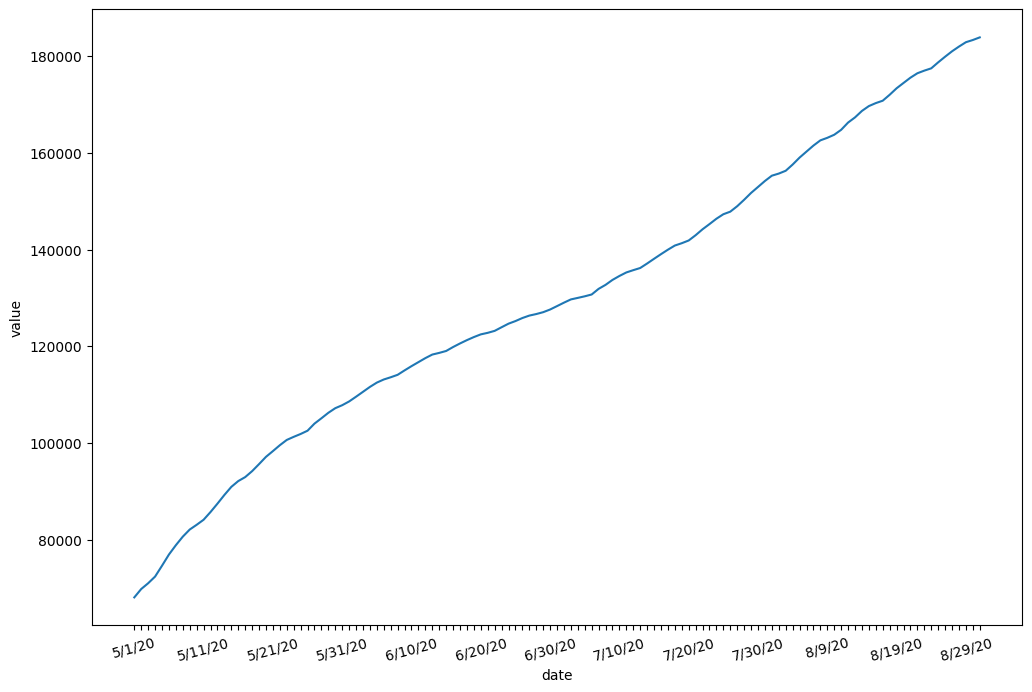

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=raw_data, x='date', y='value', ax=ax)
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 10 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xticks(rotation=15)
plt.show()


In [9]:
raw_data.set_index('date', inplace=True)
raw_data.dropna(inplace=True)
raw_data

,value
date,
5/1/20,68144
5/2/20,69875
5/3/20,71065
5/4/20,72445
5/5/20,74687
...,...
8/27/20,180943
8/28/20,181920
8/29/20,182822


In [18]:
class ARIMA(object):
    def __init__(self):
        pass
    
    @staticmethod
    def _regressor(df, n, val_col, out_pred_col, train_size=0.8):
    
        _df = df.copy()
        for i in range(1, n + 1):
            _df[f'shifted_values_{i}'] = _df[val_col].shift(i)
        _df.dropna(inplace=True)



        _train_size = int(train_size * _df.shape[0])

        _df_train = pd.DataFrame(_df[:_train_size])
        _df_test = pd.DataFrame(_df[_train_size:])

        X_train = _df_train.iloc[:, 1:].values.reshape(-1, n)
        y_train = _df_train.iloc[:, 0].values.reshape(-1, 1)
        
        X_test = _df_test.iloc[:, 1:].values.reshape(-1, n)
        y_test = _df_test.iloc[:, 0].values.reshape(-1, 1)

        lr = LinearRegression()
        lr.fit(X_train, y_train)

        theta  = lr.coef_.T
        intercept = lr.intercept_
        _df_train[out_pred_col] = X_train.dot(theta) + intercept

        _df_test[out_pred_col] = X_test.dot(theta) + intercept

        rmse = np.sqrt(mean_squared_error(y_test, _df_test[out_pred_col]))

        new_df = pd.concat([_df_train, _df_test])[[val_col, out_pred_col]]
        return new_df, theta, intercept, rmse, np.abs(_df_test[out_pred_col].mean())
    
    @staticmethod
    def AR(df, p, val_col='value', out_pred_col='predicted_value', train_size=0.8):
        return ARIMA._regressor(df, p, val_col, out_pred_col, train_size)
    
    @staticmethod
    def I(df, val_col='value', fn=None):
        _df = df.copy()
        if fn is not None:
            return pd.DataFrame(fn(_df[val_col])).dropna()
        return _df

    @staticmethod
    def MA(df, q, val_col='value', in_pred_col='predicted_value', out_pred_col='ma_predicted_value', train_size=0.8 ):
        _df = df.copy()
        _df['residual'] = _df[val_col] - _df[in_pred_col]
        return ARIMA._regressor(_df[['residual']], q, 'residual', out_pred_col, train_size)
    
    
    def fit(self, df, p, q, val_col, train_size, stationary_fn=None):
        _df = df.copy()
        stationary_df = ARIMA.I(_df, val_col, stationary_fn)

        
        ar_out_df, ar_theta, ar_intercept, ar_rmse, ar_mean_pred = ARIMA.AR(stationary_df, p, val_col, 'ar_predicted_value', train_size)

        ma_out_df, ma_theta, ma_intercept, ma_rmse, ma_mean_pred = ARIMA.MA(ar_out_df, q, val_col, 'ar_predicted_value', 'ma_predicted_value', train_size)

        stationary_df['prediction'] = ar_out_df['ar_predicted_value'] + ma_out_df['ma_predicted_value']
        return stationary_df.dropna(), ar_theta, ar_intercept, ma_theta, ma_intercept, ar_rmse, ma_rmse, ar_mean_pred, ma_mean_pred

In [19]:
arima_model = ARIMA()


In [20]:

stationary_fn = lambda x: x.diff().diff()
def reverse_stationary_fn(ori_x, new_x):
    x = new_x.copy()
    x = x + ori_x.shift(1)
    x = x + ori_x.diff().shift(1)
    return x

min_ar_rmse = float('inf')
min_ma_rmse = float('inf')
best_ar_mean_pred = None
best_ma_mean_pred = None
best_p = 1
best_q = 1

for i in range(1, 21):
    final_predictions, \
        ar_theta, ar_intercept, \
        ma_theta, ma_intercept, \
        ar_rmse, ma_rmse, \
        ar_mean_pred, ma_mean_pred = arima_model.fit(raw_data, i, best_q, 'value', TRAIN_SIZE, stationary_fn)

    if ar_rmse < min_ar_rmse:
        min_ar_rmse = ar_rmse
        best_ar_mean_pred = ar_mean_pred
        best_p = i

            
for j in range(1, 21):
    final_predictions, \
        ar_theta, ar_intercept, \
        ma_theta, ma_intercept, \
        ar_rmse, ma_rmse, \
        ar_mean_pred, ma_mean_pred = arima_model.fit(raw_data, best_p, j, 'value', TRAIN_SIZE, stationary_fn)

    if ma_rmse < min_ma_rmse:
        min_ma_rmse = ma_rmse
        best_ma_mean_pred = ma_mean_pred
        best_q = j

         value
date          
5/3/20  -541.0
5/4/20   190.0
5/5/20   862.0
5/6/20    72.0
5/7/20  -385.0
...        ...
8/27/20  -50.0
8/28/20 -139.0
8/29/20  -75.0
8/30/20 -448.0
8/31/20   88.0

[121 rows x 1 columns]
           residual
date               
5/4/20   226.102966
5/5/20   848.191039
5/6/20    12.307570
5/7/20  -390.752043
5/8/20  -140.548553
...             ...
8/27/20  -46.056429
8/28/20 -136.422008
8/29/20  -66.345180
8/30/20 -443.715034
8/31/20  117.753022

[120 rows x 1 columns]
         value
date          
5/3/20  -541.0
5/4/20   190.0
5/5/20   862.0
5/6/20    72.0
5/7/20  -385.0
...        ...
8/27/20  -50.0
8/28/20 -139.0
8/29/20  -75.0
8/30/20 -448.0
8/31/20   88.0

[121 rows x 1 columns]
           residual
date               
5/5/20   667.027176
5/6/20    44.602437
5/7/20  -107.747869
5/8/20   -98.650921
5/9/20  -400.785395
...             ...
8/27/20  210.012117
8/28/20 -154.005624
8/29/20  -73.932878
8/30/20 -482.934526
8/31/20  113.933724

[119 rows x 1 col

In [13]:
print(f'Min RMSE of AR model: {min_ar_rmse} (relative err: {min_ar_rmse/best_ar_mean_pred}). Best P: {best_p}')
print(f'Min RMSE of MA model: {min_ma_rmse} (relative err: {min_ma_rmse/best_ma_mean_pred}). Best Q: {best_q}')

Min RMSE of AR model: 108.61435447107779 (relative err: 13.299693373553117). Best P: 14
Min RMSE of MA model: 104.68471297832942 (relative err: 142.5768746807609). Best Q: 1


In [14]:
final_predictions, \
    ar_theta, ar_intercept, \
    ma_theta, ma_intercept, \
    ar_rmse, ma_rmse, \
    ar_mean_pred, ma_mean_pred = arima_model.fit(raw_data, 14, 12, 'value', TRAIN_SIZE, stationary_fn)

<Axes: xlabel='date'>

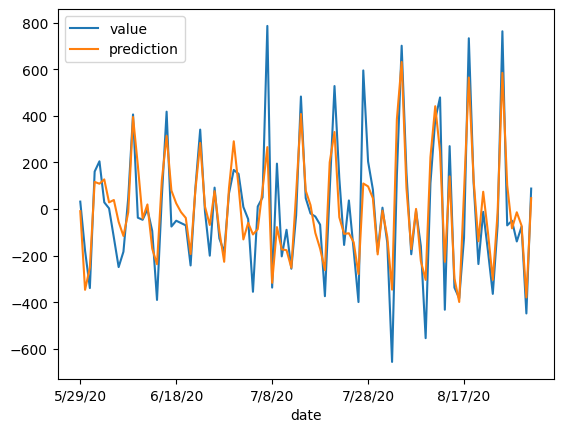

In [15]:
final_predictions.plot()

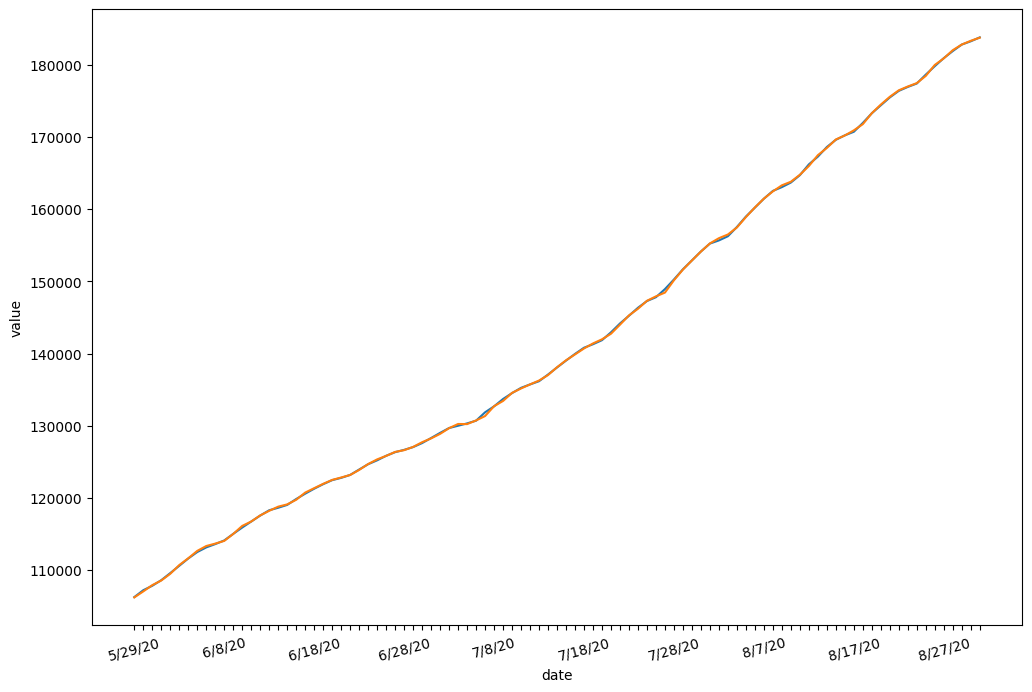

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=pd.DataFrame(reverse_stationary_fn(raw_data['value'], final_predictions['value'])).reset_index(), x='date', y='value', ax=ax)
sns.lineplot(data=pd.DataFrame(reverse_stationary_fn(raw_data['value'], final_predictions['prediction'])).reset_index(), x='date', y='prediction', ax=ax)
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xticks(rotation=15)
plt.show()